# Validation of Calcium Imaging Recordings
## Homogeneity and Stability

In [23]:
import numpy as np

import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import seaborn as sns
import pickle
import os

sns.set()
sns.set_style("whitegrid")

from scipy.signal import medfilt 

from scipy.stats import skew, kurtosis, zscore

from scipy import signal

from sklearn.linear_model import LinearRegression, TheilSenRegressor

plt.rcParams['figure.figsize'] = [16, 8]

color_awake = (0,191/255,255/255)
color_mmf = (245/255,143/255,32/255)
color_keta = (181./255,34./255,48./255)
color_iso = (143./255,39./255,143./255)

custom_palette ={'keta':color_keta, 'iso':color_iso,'fenta':color_mmf,'awa':color_awake}

# Useful functions for the analysis

from capipeline import *

In [3]:
if 'google.colab' in str(get_ipython()): 
  print('Running on CoLab')
  !wget https://raw.githubusercontent.com/mchini/Yang_Chini_et_al/testTransition/notebooks/capipeline.py
  !git clone https://github.com/j-friedrich/OASIS.git
  !pwd
  %cd /content/OASIS/
  !pwd
  import warnings
  warnings.filterwarnings("ignore")
  !python setup.py build_ext --inplace
  %cd ..
  !pwd
  from sys import path
  path.append(r'/content/OASIS')
    
else:    
  print('Not running on CoLab')
  print('If you still want to install OASIS this way: remove the if-condition in this cell')

Not running on CoLab
If you still want to install OASIS this way just remove the *if*-condition inside this cell


### Upload ready-to-use dataframe or re-run the analysis the analysis 

This notebook illustrates the basic analysis of homogeneity and stability of calcium imaging recordings.

### Colab mode

As the uploading of all data may take significant time, we suggest starting with a ready-to-use dataframe  *df_estimators* that contains basic information regarding the stability of the recordings, such as 

- total number of identified neurons,
- traces and neuropils median intensities for each ROI
- their standard deviation
- skewness of the signal
- estimation of their baseline (defined as a bottom quartile of signal intensities) 
- their temporal stability (defined as the ratio between median signals of all ROIs in the first and the second part of the recording)  
- and several others

If the data is fully downloaded, the notebook may alternatively create a new, fresh *df_estimators* dataframe.

### To run the analysis from scratch:

1) download suite2p preprocessed data together with its description (*meta_recordings - anesthesia.xlsx* file)

2) change the *database_path* variable to link *meta_recordings - anesthesia.xlsx* file. 

3) change paths to the data in *meta_recordings - anesthesia.xlsx* file

4) Set full_data_analysis = True

In [9]:
full_data_analysis = False

is_colab = 'google.colab' in str(get_ipython())

if is_colab or not(full_data_analysis):
    
    if is_colab:
        print('Running on CoLab')      
    print('Download dataframe:')
    !wget "https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/ae8aee09e056607672ff2435400e025d01a5fe7b/validation/calcium_imaging/calcium_imaging_stability_validation.pkl"
    df_estimators = pd.read_pickle("./calcium_imaging_stability_validation.pkl")
    
else:  
    
    print('Not running on CoLab')
    print('For starting the analysis from scratch:')
    print('1) download full suite2p reprocessed data together with the description, meta_recordings - anesthesia.xlsx file')
    print('2) change the *database_path* variable to link meta_recordings - anesthesia.xlsx file') 
    print('3) change paths to the data in *meta_recordings - anesthesia.xlsx* file')    

    database_path = 'your path../Anesthesia_CA1/meta_data/meta_recordings - anesthesia.xlsx'

    df_estimators = pd.DataFrame()


    for r in rec:

        Traces, Npils, n_accepted_and_rejected = traces_and_npils(r, database_path, concatenation=False)
        print("Shape: " + str(Traces.shape[0]) + " N_accept_reject: " + str(n_accepted_and_rejected))
        animal = get_animal_from_recording(r, database_path)

        condition = get_condition(r, database_path)

        print("#" +  str(r) + " " + str(animal) + " " + str(condition) + " ")

        Traces_median = ma.median(Traces, axis=1) 
        Npils_median = ma.median(Npils, axis=1)

        Traces_std = ma.std(Npils, axis=1)    
        Npils_std = ma.std(Npils, axis=1)

        Traces_skewness = skew(Traces,axis=1)
        Npils_skewness = skew(Npils,axis=1)

        baseline = np.quantile(Traces,0.25,axis=1)


        num_cells = np.shape(Traces)[0]
        decay_isol = np.zeros((num_cells))

        fs = 30 

        for neuron in np.arange(num_cells):

            if np.all(np.isnan(Traces[neuron])):
                decay_isol[neuron] = np.nan
            else:
                _, _, _, decay_neuron_isolated10, _ = deconvolve(np.double(Traces[neuron, ]),
                                                                     penalty = 0, optimize_g = 10)
                decay_isol[neuron] = - 1 / (fs * np.log(decay_neuron_isolated10))




        recording_length = int(Traces.shape[1])

        half = int(recording_length/2)

        print(recording_length)
        m1 = ma.median(Traces[:,:half])
        m2 = ma.median(Traces[:,half:])

        print("Stability:",m2/m1*100)

        norm_9000 = 9000/recording_length   # normalize to 9000 frames (5 min recording)

        traces_median_half_vs_half = norm_9000*(m2-m1)*100/m1 + 100

        print("Stability (9000 frames normalization)",traces_median_half_vs_half)

        df_e = pd.DataFrame({ "animal":animal,
                            "recording":r,
                            "condition":condition,
                            "number.neurons":Traces.shape[0],
                            "traces.median":Traces_median,
                            "npils.median":Npils_median,
                            "traces.std":Traces_std,
                            "npils.std":Npils_std,

                            "traces.skewness":Traces_skewness,
                            "npils.skewness":Npils_skewness,

                            "decay":decay_isol, 

                            "baseline.quantile.25":baseline,

                            "median.stability":traces_median_half_vs_half # in percent

                          })

        df_estimators = pd.concat([df_estimators,df_e])

        print("*****")

        df_estimators['neuronID'] = df_estimators.index
          
    #Save results
    
    df_estimators.to_pickle("./calcium_imaging_stability_validation.pkl")

Download dataframe:
--2021-06-26 21:30:15--  https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/ae8aee09e056607672ff2435400e025d01a5fe7b/validation/calcium_imaging/calcium_imaging_stability_validation.pkl
Resolving gin.g-node.org (gin.g-node.org)... 141.84.41.219
Connecting to gin.g-node.org (gin.g-node.org)|141.84.41.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘calcium_imaging_stability_validation.pkl.1’

calcium_imaging_sta     [           <=>      ]   5,16M  2,46MB/s    in 2,1s    

2021-06-26 21:30:19 (2,46 MB/s) - ‘calcium_imaging_stability_validation.pkl.1’ saved [5413911]



### Plot 

[   48    51    53 37527 37528 37529 37530]


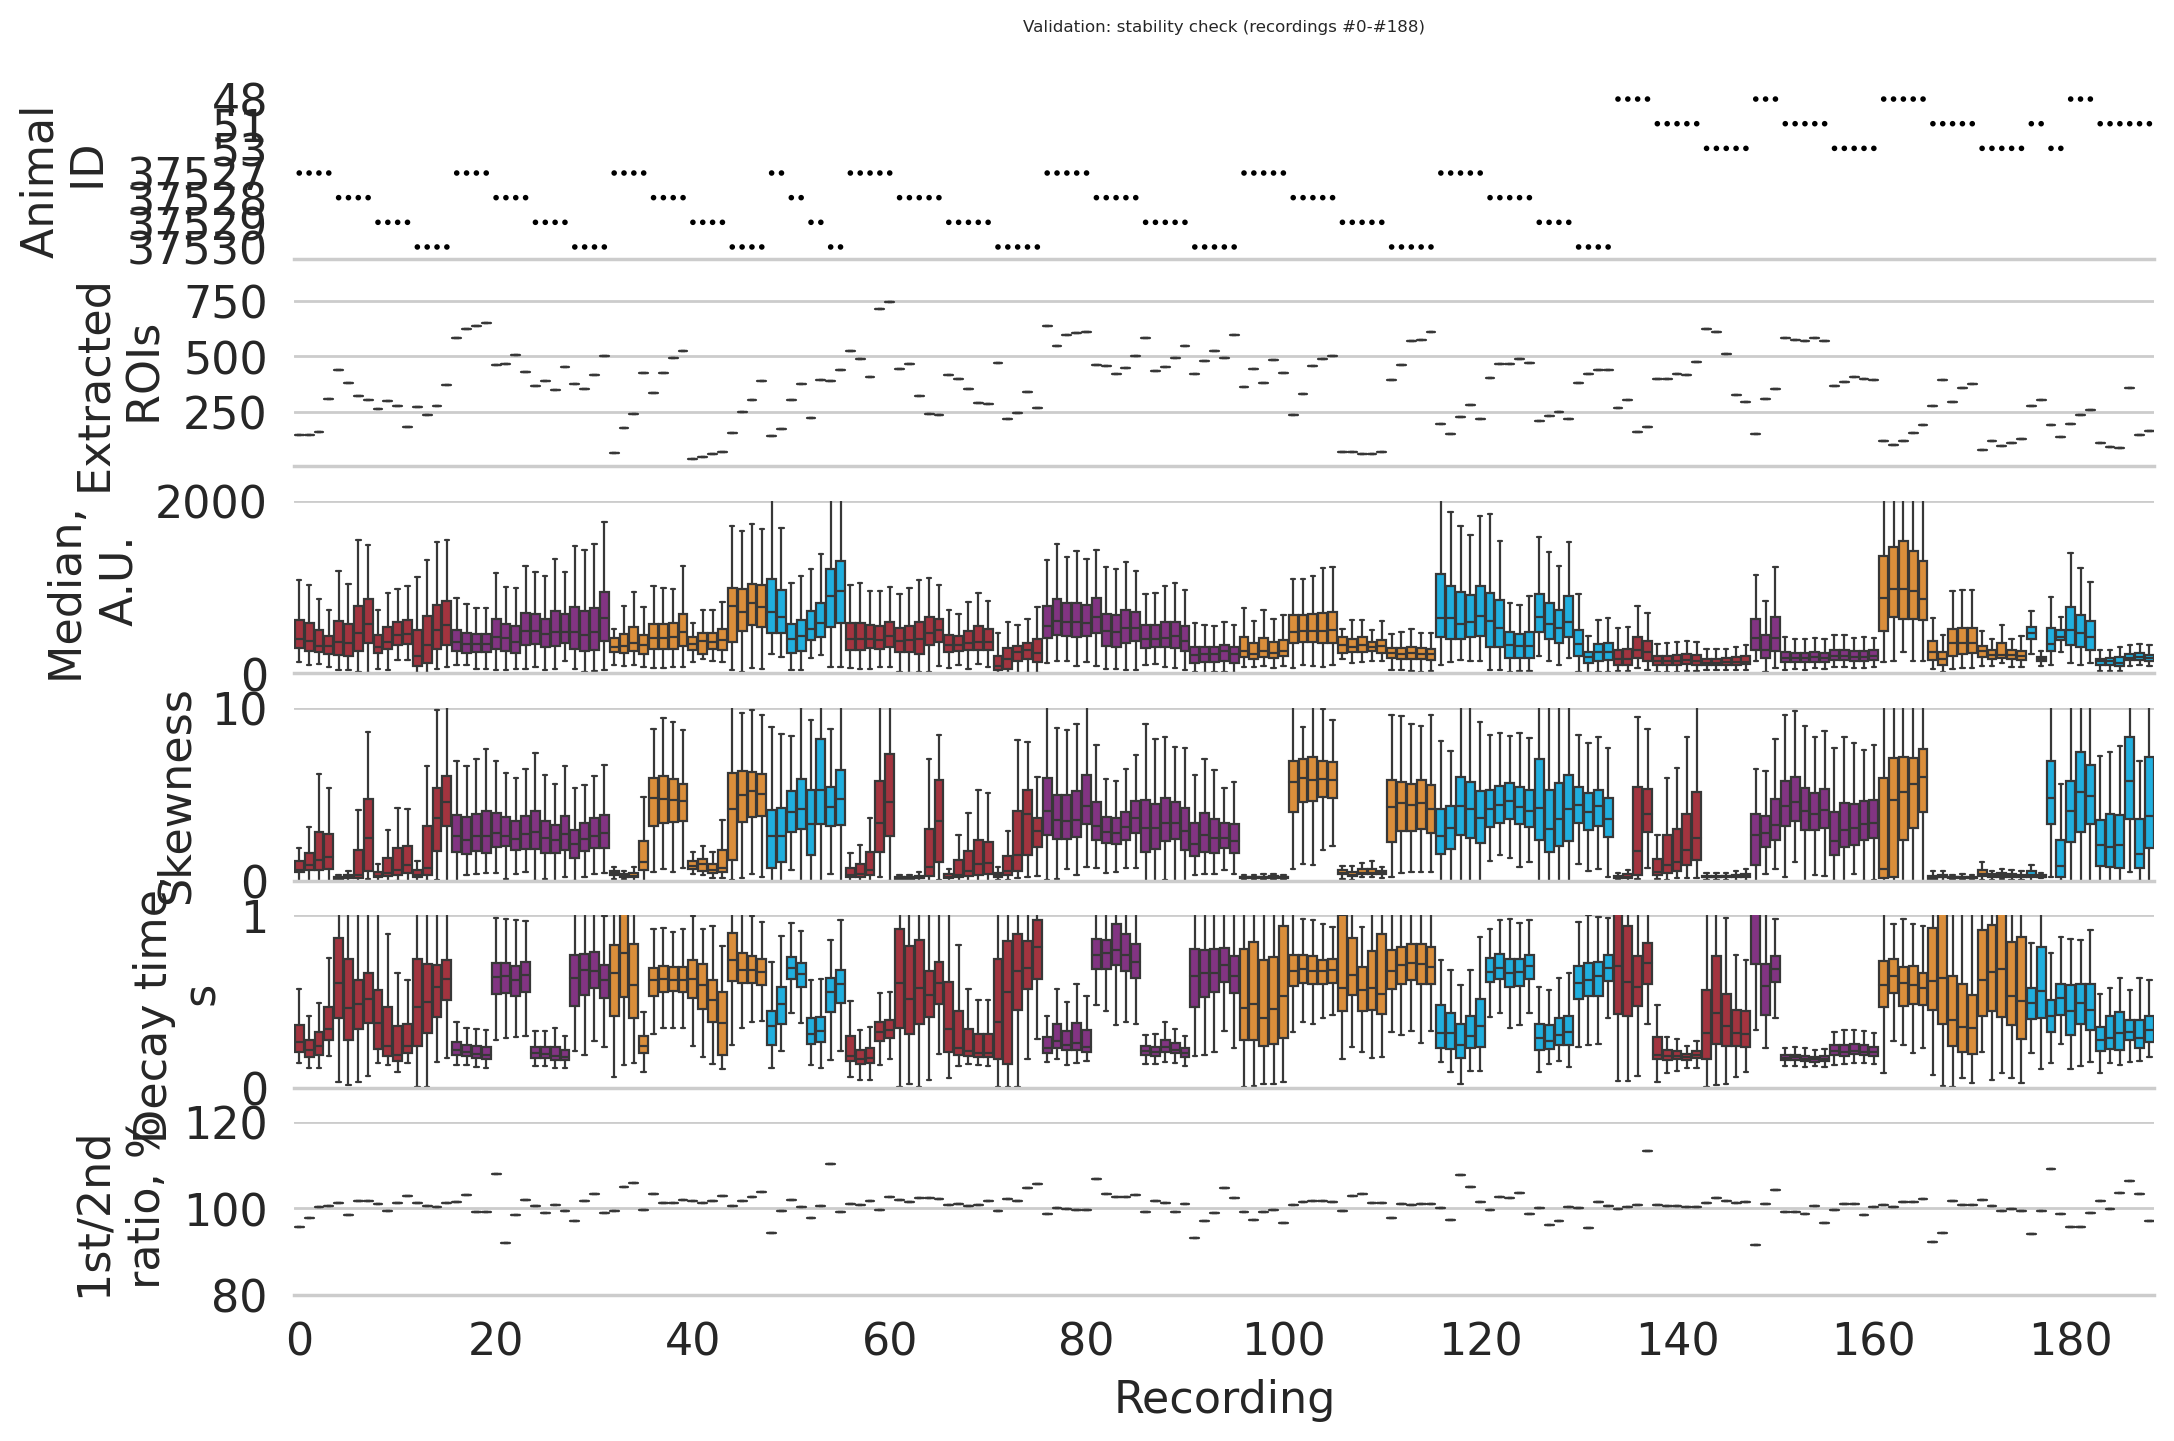

In [20]:
df_estimators["animal_cat"] = df_estimators["animal"].astype("category")

df_estimators['neuronID'] = df_estimators.index

parameters = ["animal",'number.neurons','traces.median','traces.skewness','decay','median.stability']
labels = ["Animal \n ID",'Extracted \n ROIs','Median, \n A.U.','Skewness','Decay time, \n s','1st/2nd \n ratio, %']
number_subplots = len(parameters)
recordings_ranges = [[0,188]]

for rmin,rmax in recordings_ranges:

    f, axes = plt.subplots(number_subplots, 1, figsize=(12, 8),dpi=200) # sharex=Truerex=True
    sns.despine(left=True)

    for i, param in enumerate(parameters):
        
        lw = 0.8

        #else:
        sns.boxplot(x='recording', y=param, data=df_estimators[(df_estimators.recording>=rmin)&(df_estimators.recording<=rmax)], width=0.9, dodge=False, showfliers = False,hue='condition', palette=custom_palette,ax=axes[i],linewidth=lw)
        if (i == 0):
            param = "animal_cat"
            print(np.unique(df_estimators[param]))
            axes[i].set_yticks(np.unique(df_estimators[param]))
 
            sns.swarmplot(x='recording', y=param, data=df_estimators[(df_estimators.recording>=rmin)&(df_estimators.recording<=rmax)&(df_estimators['neuronID'] == 0)],dodge=False,  s=1,  edgecolor='black', linewidth=1, hue='condition', palette=custom_palette, ax=axes[i])
            #ax.set(ylabel="")
      
        if i > 1:
            axes[i].set_ylim([0.0,2000.0])
        if i > 2:
            axes[i].set_ylim([0.0,10.0])
        if i > 3:
            axes[i].set_ylim([0.0,1.0])
        if i > 4:
            axes[i].set_ylim([80,120])
            axes[i].get_xaxis().set_visible(True)
        else:
            axes[i].get_xaxis().set_visible(False)
           
        if i < number_subplots-1:
            axes[i].xaxis.label.set_visible(False)
        if i==0:
            axes[i].set_title("Validation: stability check (recordings #%d-#%d)" % (rmin,rmax), fontsize=6, pad=20)
        axes[i].set_ylabel(labels[i], fontsize=16,labelpad=5)
        axes[i].set_xlabel("Recording", fontsize=16,labelpad=5)
        #axes[i].axis('off')

        axes[i].xaxis.set_tick_params(labelsize=16)
        axes[i].yaxis.set_tick_params(labelsize=16)

        axes[i].get_legend().remove()
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(20))
        axes[i].xaxis.set_major_formatter(ticker.ScalarFormatter())

        

    #plt.legend(loc='upper right',fontsize=8)
    #plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,fontsize=9)
    plt.savefig("Validation_stability_check_rec_#%d-#%d).png" % (rmin,rmax),dpi=300)
    plt.savefig("Validation_stability_check_rec_#%d-#%d).svg" % (rmin,rmax))
    #plt.show()

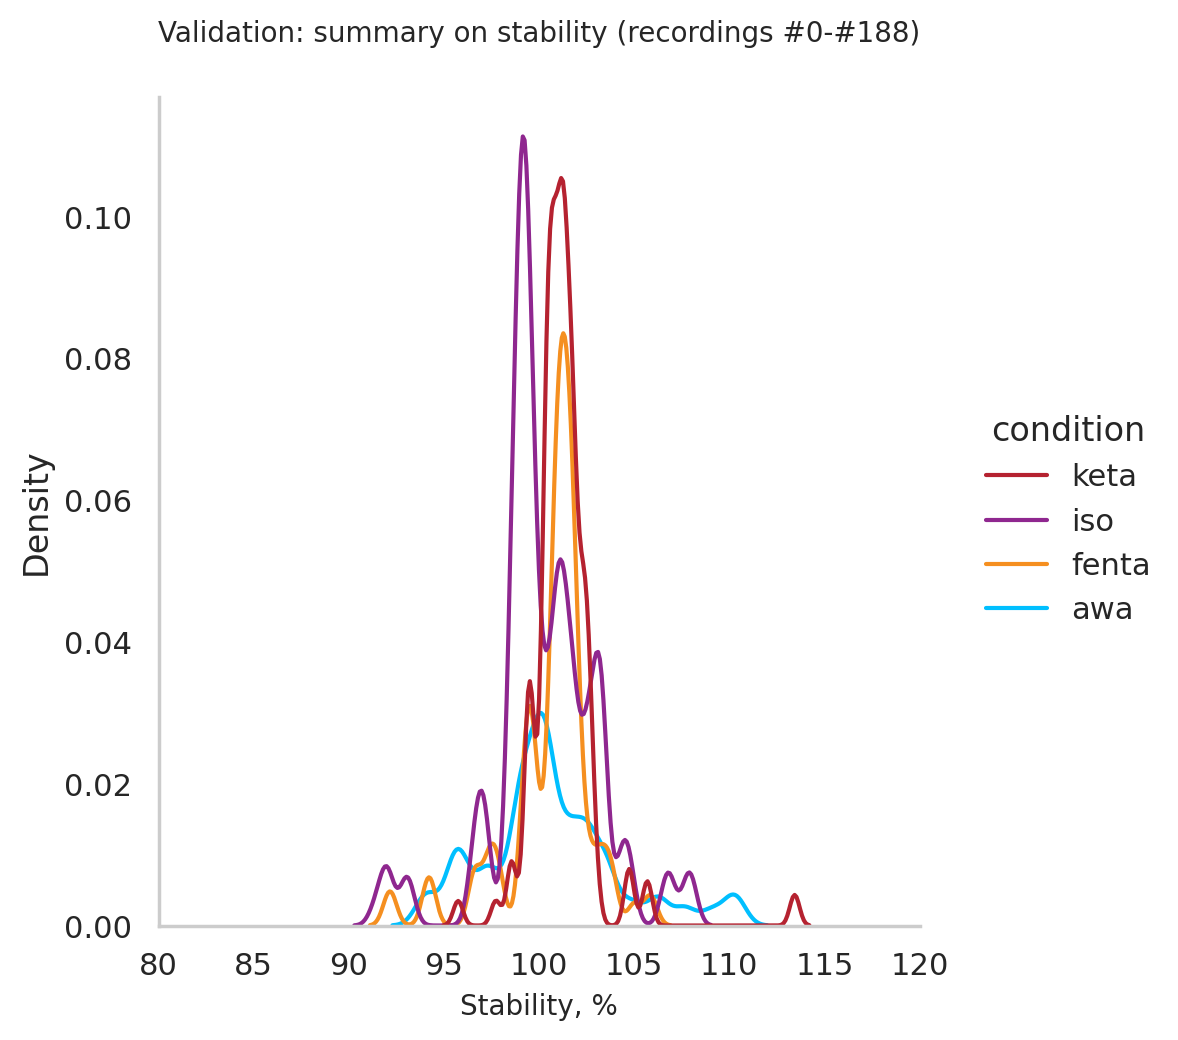

In [26]:
plt.rcParams['figure.figsize'] = [5, 5]

sns.displot(data=df_estimators, x="median.stability", hue = 'condition',palette=custom_palette, kind="kde")
plt.xlim([80,120])
plt.xlabel("Stability, %", fontsize = 10)
plt.title("Validation: summary on stability (recordings #%d-#%d)" % (min(rec),max(rec)), fontsize = 10, pad=20)
plt.grid(False)
plt.savefig("Validation_summary_stability_recordings_#%d-#%d)" % (min(rec),max(rec)))
#plt.show()

In [ ]:
### Get statistics

In [62]:
df_estimators["median.stability"].describe()

count    65887.000000
mean        98.883782
std          2.614005
min         90.832418
25%         97.582144
50%         98.731375
75%        100.151229
max        108.073246
Name: median.stability, dtype: float64